In [21]:
"""
The purpose of this Jupyter notebook is to superimpose ROC curves so as
to summarize them. These summarized ROC curves are supposed to be used
in the manuscript of the publication.

On the one hand, ROC curve data is available for two measurement
channels, which are early and late intensities. On the other hand, ROC
curve data is also available for both high intensity hits and low
intensity hits. Yet another layer of complexity stems from the fact that
refinement has been conducted using four different summary statistics,
which are the maximum, the mean, the median and the sum of the predicted
PPI probabilities.

Thus, the ROC curves are summarized in the following manner: For each
measurement channel (early/late) and each hit type (high/low intensity),
the four different ways of refinement are superimposed, yielding plots
with four different superimposed ROC curves.

In the case of unrefined intensity values, each plot contains only one
ROC curve.
"""

'\nThe purpose of this Jupyter notebook is to superimpose ROC curves so as\nto summarize them. These summarized ROC curves are supposed to be used\nin the manuscript of the publication.\n\nOn the one hand, ROC curve data is available for two measurement\nchannels, which are early and late intensities. On the other hand, ROC\ncurve data is also available for both high intensity hits and low\nintensity hits. Yet another layer of complexity stems from the fact that\nrefinement has been conducted using four different summary statistics,\nwhich are the maximum, the mean, the median and the sum of the predicted\nPPI probabilities.\n\nThus, the ROC curves are summarized in the following manner: For each\nmeasurement channel (early/late) and each hit type (high/low intensity),\nthe four different ways of refinement are superimposed, yielding plots\nwith four different superimposed ROC curves.\n\nIn the case of unrefined intensity values, each plot contains only one\nROC curve.\n'

In [22]:
import os

import pandas as pd
from matplotlib import pyplot as plt

### Defining a Function for Superimposing ROC Curves

In [50]:
# For the sake of convenience, a function superimposing ROC curves is
# defined
def superimpose_roc_curves(
        roc_data_list, auc_score_list, descriptor_list, image_dir,
        fname_info, best_in_bold=False
):
    """
    Superimposes ROC curves, i.e. generates one plot depicting multiple
    ROC curves.

    Parameters
    ----------
    roc_data_list: list, dtype=Pandas DataFrame, shape=(n,)
        A list containing one Pandas DataFrame for each ROC curve to
        plot. The Pandas DataFrames must comprise three columns bearing
        the names `FPR`, `TPR` and `Threshold`.
    auc_score_list: list, dtype=float, shape=(n,)
        A list storing the AUC scores associated with the ROC curves in
        `roc_data_list` in the correct order.
    descriptor_list: list, dtype=str, shape=(n,)
        A list comprising short descriptions of the ROC curves in
        `roc_data_list` in the corresponding order. These descriptions
        appear in the figure legend.
    image_dir: str
        A string denoting the path to the directory to store the image
        in.
    fname_info: str
        Information on the ROC curves appearing in the file name.
    best_in_bold: bool, optional, default=False
        A Boolean indicating whether the legend entry associated with
        the best AUC score is displayed in bold. By default, it is not.

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(1, 1)

    ax.set_xlabel("False Positive Rate", fontsize=20) # original font size: 15
    ax.set_ylabel("True Positive Rate", fontsize=20)

    ax.tick_params(labelsize=17)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.05)

    # Plot the dashed diagonal line representing a random chance model
    ax.plot([0, 1], [0, 1], lw=2, linestyle="--")

    # Now, plot the individual ROC curves
    for roc_curve_df, auc_score, description in zip(
        roc_data_list, auc_score_list, descriptor_list
    ):
        ax.plot(
            roc_curve_df["FPR"],
            roc_curve_df["TPR"],
            lw=2,
            label=f"{description} (AUC={auc_score:.3f})"
        )

    # Add a legend to the figure displaying the AUC scores of the
    # individual ROC curves
    leg = ax.legend(loc="best", fontsize=13)

    if best_in_bold:
        # Determine the indices of the best AUC score
        best_auc_idx = [
            i for i, auc in enumerate(auc_score_list)
            if auc == max(auc_score_list)
        ]

        for i, text in enumerate(leg.get_texts()):
            if i in best_auc_idx:
                text.set_fontweight("bold")

    fig.tight_layout()

    # The figure is saved twice, once as a PNG and once as an SVG (for
    # the publication)
    fig.savefig(
        os.path.join(
            image_dir,
            f"ROC_curves_{fname_info}.png"
        ),
        dpi=300
    )

    fig.savefig(
        os.path.join(
            image_dir,
            f"ROC_curves_{fname_info}.svg"
        )
    )

### Generating Superimposed ROC Curves for Unnormalized Intensity Values

In [51]:
# Create a subdirectory to store the plots in
unnorm_refined_subdir_name = "unnormalized_intensity_values"

if not os.path.exists(unnorm_refined_subdir_name):
    os.makedirs(unnorm_refined_subdir_name)

In [52]:
# Two different types of ROC plots are supposed to be generated
# One of them is placed in the supplementary material and thus contains
# all curves (unrefined, max, mean, median and sum)
# The other is placed in figure 1 und must be accordingly concise; thus,
# only two curves are depicted, which are the unrefined and the refined
# performance (for the refined performance, the best performing
# refinement mode is taken, which is median)
# Create subdirectories for these two types of plots
suppl_mat_subdir_name = "supplementary_material_plots"

if not os.path.exists(
    os.path.join(unnorm_refined_subdir_name, suppl_mat_subdir_name)
):
    os.makedirs(
        os.path.join(unnorm_refined_subdir_name, suppl_mat_subdir_name)
    )

fig_1_subdir_name = "figure_1_plots"

if not os.path.exists(
    os.path.join(unnorm_refined_subdir_name, fig_1_subdir_name)
):
    os.makedirs(
        os.path.join(unnorm_refined_subdir_name, fig_1_subdir_name)
    )

In [53]:
# Load the TSV files storing the curve data after refinement into Pandas
# DataFrames
# Bear in mind that data is available for both early and late
# intensities and also for both high and low intensity hits
refinement_modes = [
    "max",
    "mean",
    "median",
    "sum"
]

unnorm_refined_high_dir = "../refined_unnormalized_intensity_values"
unnorm_high_early_df_list = []
unnorm_high_late_df_list = []

for mode in refinement_modes:
    current_early_path = os.path.join(
        unnorm_refined_high_dir,
        f"{mode}_refinement",
        "roc_curve_data_early_VoronoiCells.tsv"
    )
    current_early_df = pd.read_csv(
        current_early_path,
        sep="\t"
    )
    unnorm_high_early_df_list.append(current_early_df)

    current_late_path = os.path.join(
        unnorm_refined_high_dir,
        f"{mode}_refinement",
        "roc_curve_data_late_VoronoiCells.tsv"
    )
    current_late_df = pd.read_csv(
        current_late_path,
        sep="\t"
    )
    unnorm_high_late_df_list.append(current_late_df)


unnorm_refined_low_dir = (
    "../four_hit_lists_approach/unnormalized_refined_intensity_values"
)
unnorm_low_early_df_list = []
unnorm_low_late_df_list = []

for mode in refinement_modes:
    current_early_path = os.path.join(
        unnorm_refined_low_dir,
        f"{mode}_refinement",
        "roc_curve_data_early_VoronoiCells.tsv"
    )
    current_early_df = pd.read_csv(
        current_early_path,
        sep="\t"
    )
    unnorm_low_early_df_list.append(current_early_df)

    current_late_path = os.path.join(
        unnorm_refined_low_dir,
        f"{mode}_refinement",
        "roc_curve_data_late_VoronoiCells.tsv"
    )
    current_late_df = pd.read_csv(
        current_late_path,
        sep="\t"
    )
    unnorm_low_late_df_list.append(current_late_df)

In [54]:
# Now, load the TSV files storing the curve data before refinement into
# Pandas DataFrames
# Again, bear in mind that data is available for both early and late
# intensities and also for both high and low intensity hits

# Curve data for early high intensity hits
unnorm_unrefined_high_early_path = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/roc_curves_and_related_data/"
    "unrefined_unnormalized_intensity_values/roc_curve_data_early_"
    "VoronoiCells.tsv"
)
unnorm_unrefined_high_early_df = pd.read_csv(
    unnorm_unrefined_high_early_path,
    sep="\t"
)
unnorm_high_early_df_list.insert(0, unnorm_unrefined_high_early_df)

# Curve data for late high intensity hits
unnorm_unrefined_high_late_path = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/roc_curves_and_related_data/"
    "unrefined_unnormalized_intensity_values/roc_curve_data_late_"
    "VoronoiCells.tsv"
)
unnorm_unrefined_high_late_df = pd.read_csv(
    unnorm_unrefined_high_late_path,
    sep="\t"
)
unnorm_high_late_df_list.insert(0, unnorm_unrefined_high_late_df)

# Curve data for early low intensity hits
unnorm_unrefined_low_early_path = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/roc_curves_and_related_data/four_hit_"
    "lists_approach/unnormalized_unrefined_intensity_values/roc_curve_"
    "data_early_VoronoiCells.tsv"
)
unnorm_unrefined_low_early_df = pd.read_csv(
    unnorm_unrefined_low_early_path,
    sep="\t"
)
unnorm_low_early_df_list.insert(0, unnorm_unrefined_low_early_df)

# Curve data for late low intensity hits
unnorm_unrefined_low_late_path = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/roc_curves_and_related_data/four_hit_"
    "lists_approach/unnormalized_unrefined_intensity_values/roc_curve_"
    "data_late_VoronoiCells.tsv"
)
unnorm_unrefined_low_late_df = pd.read_csv(
    unnorm_unrefined_low_late_path,
    sep="\t"
)
unnorm_low_late_df_list.insert(0, unnorm_unrefined_low_late_df)

In [55]:
# Define four AUC score lists
# The order of the ROC curve DataFrames is as follows:
# unrefined, max, mean, median, sum
unnorm_high_early_auc_list = [0.5914, 0.7143, 0.8992, 0.9055, 0.8992]
unnorm_high_late_auc_list = [0.6092, 0.7952, 0.8739, 0.8855, 0.8739]

unnorm_low_early_auc_list = [0.4086, 0.7279, 0.9212, 0.9191, 0.9212]
unnorm_low_late_auc_list = [0.3908, 0.6660, 0.8981, 0.9065, 0.8981]

In [56]:
descriptions = ["unrefined"] + refinement_modes

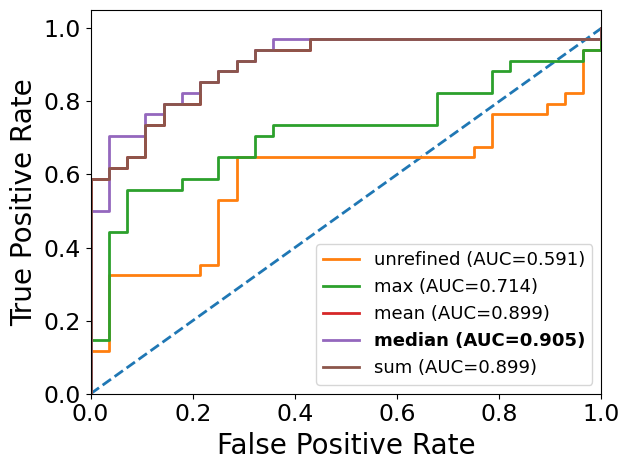

In [57]:
# Superimpose ROC curves for early high intensity hits
# Generate the supplementary material figure
superimpose_roc_curves(
    unnorm_high_early_df_list,
    unnorm_high_early_auc_list,
    descriptions,
    os.path.join(unnorm_refined_subdir_name, suppl_mat_subdir_name),
    "early_high_intensity_hits",
    best_in_bold=True
)

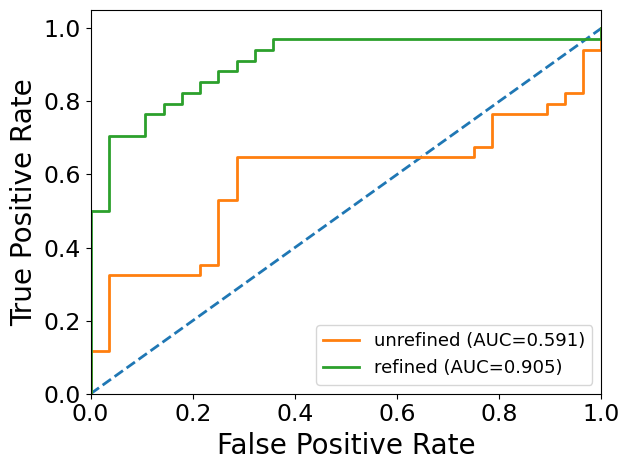

In [58]:
# Generate the plot for figure 1
# To this end, the required elements have to be extracted from the lists
# The elements of interest are located at indices 0 (unrefined) and 3
# (median-refined)
fig_1_indices = [0, 3]
fig_1_unnorm_high_early_df_list = [
    unnorm_high_early_df_list[i] for i in fig_1_indices
]
fig_1_unnorm_high_early_auc_list = [
    unnorm_high_early_auc_list[i] for i in fig_1_indices
]

fig_1_descriptions = ["unrefined", "refined"]

superimpose_roc_curves(
    fig_1_unnorm_high_early_df_list,
    fig_1_unnorm_high_early_auc_list,
    fig_1_descriptions,
    os.path.join(unnorm_refined_subdir_name, fig_1_subdir_name),
    "early_high_intensity_hits"
)

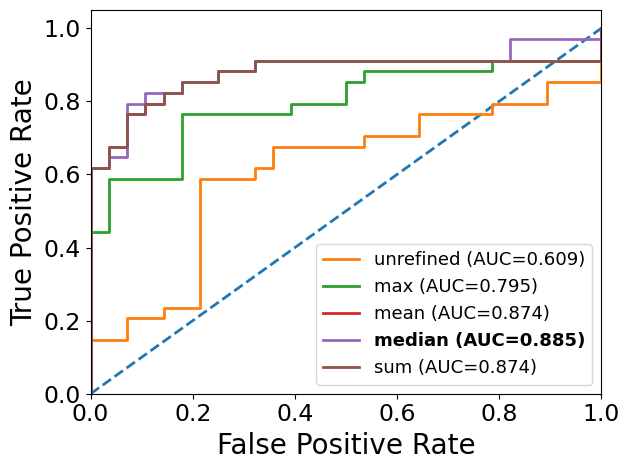

In [59]:
# Superimpose ROC curves for late high intensity hits
# Generate the supplementary material figure
superimpose_roc_curves(
    unnorm_high_late_df_list,
    unnorm_high_late_auc_list,
    descriptions,
    os.path.join(unnorm_refined_subdir_name, suppl_mat_subdir_name),
    "late_high_intensity_hits",
    best_in_bold=True
)

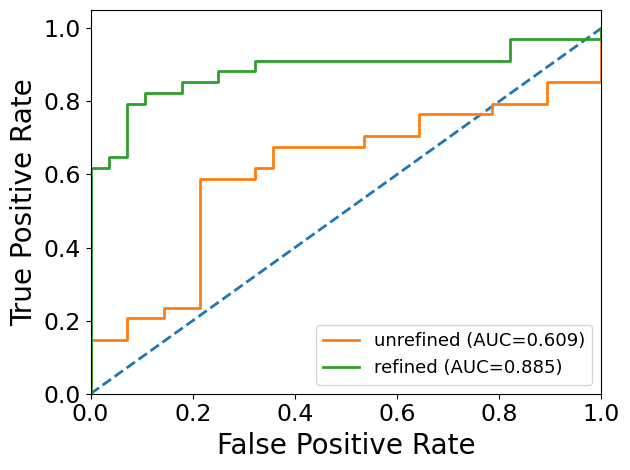

In [60]:
# Generate the plot for figure 1
# Extract the required elements located at indices 0 and 3
fig_1_unnorm_high_late_df_list = [
    unnorm_high_late_df_list[i] for i in fig_1_indices
]
fig_1_unnorm_high_late_auc_list = [
    unnorm_high_late_auc_list[i] for i in fig_1_indices
]

superimpose_roc_curves(
    fig_1_unnorm_high_late_df_list,
    fig_1_unnorm_high_late_auc_list,
    fig_1_descriptions,
    os.path.join(unnorm_refined_subdir_name, fig_1_subdir_name),
    "late_high_intensity_hits"
)

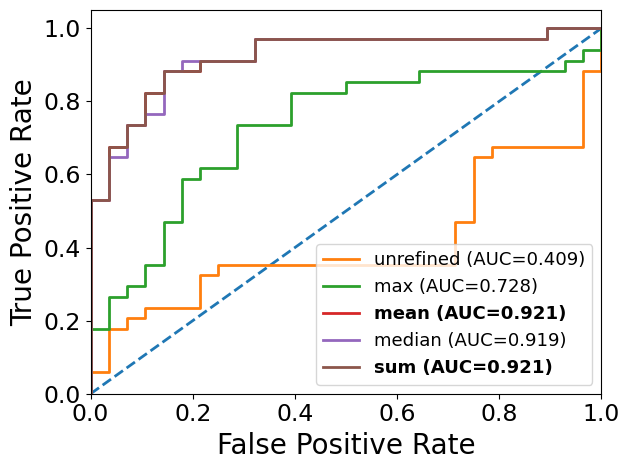

In [61]:
# Superimpose ROC curves for early low intensity hits
# Generate the supplementary material figure
superimpose_roc_curves(
    unnorm_low_early_df_list,
    unnorm_low_early_auc_list,
    descriptions,
    os.path.join(unnorm_refined_subdir_name, suppl_mat_subdir_name),
    "early_low_intensity_hits",
    best_in_bold=True
)

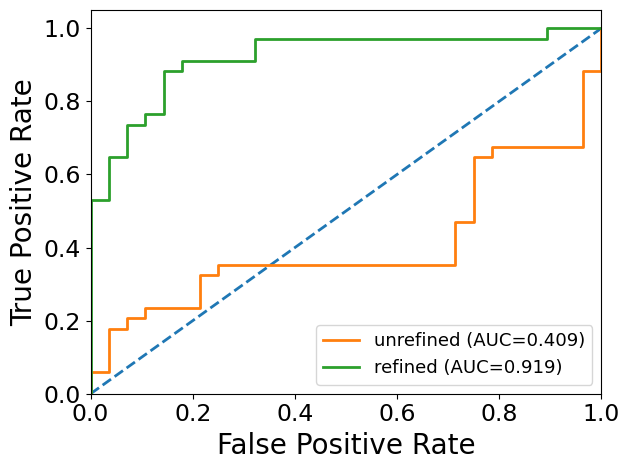

In [62]:
# Generate the plot for figure 1
# Extract the required elements located at indices 0 and 3
fig_1_unnorm_low_early_df_list = [
    unnorm_low_early_df_list[i] for i in fig_1_indices
]
fig_1_unnorm_low_early_auc_list = [
    unnorm_low_early_auc_list[i] for i in fig_1_indices
]

superimpose_roc_curves(
    fig_1_unnorm_low_early_df_list,
    fig_1_unnorm_low_early_auc_list,
    fig_1_descriptions,
    os.path.join(unnorm_refined_subdir_name, fig_1_subdir_name),
    "early_low_intensity_hits"
)

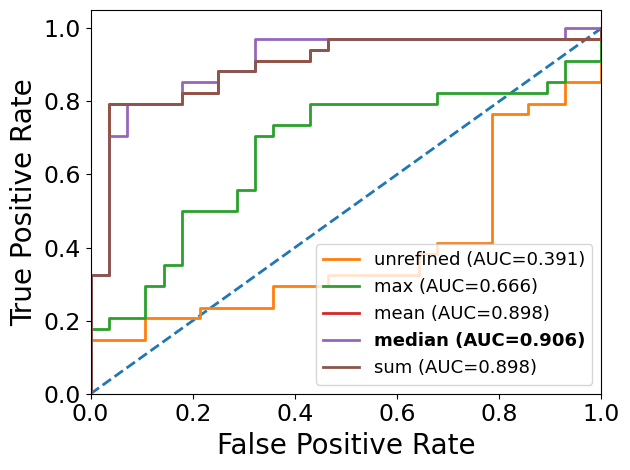

In [63]:
# Superimpose ROC curves for late low intensity hits
# Generate the supplementary material figure
superimpose_roc_curves(
    unnorm_low_late_df_list,
    unnorm_low_late_auc_list,
    descriptions,
    os.path.join(unnorm_refined_subdir_name, suppl_mat_subdir_name),
    "late_low_intensity_hits",
    best_in_bold=True
)

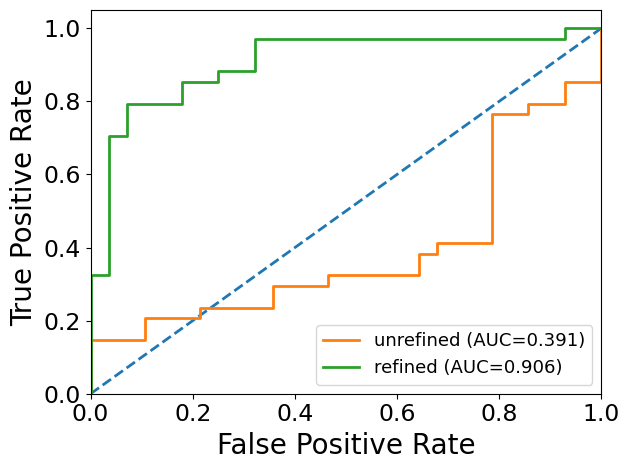

In [64]:
# Generate the plot for figure 1
# Extract the required elements located at indices 0 and 3
fig_1_unnorm_low_late_df_list = [
    unnorm_low_late_df_list[i] for i in fig_1_indices
]
fig_1_unnorm_low_late_auc_list = [
    unnorm_low_late_auc_list[i] for i in fig_1_indices
]

superimpose_roc_curves(
    fig_1_unnorm_low_late_df_list,
    fig_1_unnorm_low_late_auc_list,
    fig_1_descriptions,
    os.path.join(unnorm_refined_subdir_name, fig_1_subdir_name),
    "late_low_intensity_hits"
)

### Generating Superimposed ROC Curves for IQM-Normalized Intensity Values

In [65]:
# Create a subdirectory to store the plots in
iqm_norm_refined_subdir_name = "IQM-normalized_intensity_values"

if not os.path.exists(iqm_norm_refined_subdir_name):
    os.makedirs(iqm_norm_refined_subdir_name)

In [66]:
# As for the unnormalized intensity values, two different types of ROC
# plots are supposed to be generated
# Thus, two subdirectories are created for these two types of plots
if not os.path.exists(
    os.path.join(iqm_norm_refined_subdir_name, suppl_mat_subdir_name)
):
    os.makedirs(
        os.path.join(iqm_norm_refined_subdir_name, suppl_mat_subdir_name)
    )

if not os.path.exists(
    os.path.join(iqm_norm_refined_subdir_name, fig_1_subdir_name)
):
    os.makedirs(
        os.path.join(iqm_norm_refined_subdir_name, fig_1_subdir_name)
    )

In [67]:
# Load the TSV files storing the curve data after refinement into Pandas
# DataFrames
# Bear in mind that data is available for both early and late
# intensities and also for both high and low intensity hits
iqm_norm_refined_high_dir = "../refined_normalized_intensity_values"
iqm_norm_high_early_df_list = []
iqm_norm_high_late_df_list = []

for mode in refinement_modes:
    current_early_path = os.path.join(
        iqm_norm_refined_high_dir,
        f"{mode}_refinement",
        "roc_curve_data_early_VoronoiCells.tsv"
    )
    current_early_df = pd.read_csv(
        current_early_path,
        sep="\t"
    )
    iqm_norm_high_early_df_list.append(current_early_df)

    current_late_path = os.path.join(
        iqm_norm_refined_high_dir,
        f"{mode}_refinement",
        "roc_curve_data_late_VoronoiCells.tsv"
    )
    current_late_df = pd.read_csv(
        current_late_path,
        sep="\t"
    )
    iqm_norm_high_late_df_list.append(current_late_df)


iqm_norm_refined_low_dir = (
    "../four_hit_lists_approach/IQM-normalized_refined_intensity_values"
)
iqm_norm_low_early_df_list = []
iqm_norm_low_late_df_list = []

for mode in refinement_modes:
    current_early_path = os.path.join(
        iqm_norm_refined_low_dir,
        f"{mode}_refinement",
        "roc_curve_data_early_VoronoiCells.tsv"
    )
    current_early_df = pd.read_csv(
        current_early_path,
        sep="\t"
    )
    iqm_norm_low_early_df_list.append(current_early_df)

    current_late_path = os.path.join(
        iqm_norm_refined_low_dir,
        f"{mode}_refinement",
        "roc_curve_data_late_VoronoiCells.tsv"
    )
    current_late_df = pd.read_csv(
        current_late_path,
        sep="\t"
    )
    iqm_norm_low_late_df_list.append(current_late_df)

In [68]:
# Now, load the TSV files storing the curve data before refinement into
# Pandas DataFrames
# Again, bear in mind that data is available for both early and late
# intensities and also for both high and low intensity hits

# Curve data for early high intensity hits
iqm_norm_unrefined_high_early_path = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/roc_curves_and_related_data/"
    "unrefined_IQM-normalized_intensity_values/roc_curve_data_early_"
    "VoronoiCells.tsv"
)
iqm_norm_unrefined_high_early_df = pd.read_csv(
    iqm_norm_unrefined_high_early_path,
    sep="\t"
)
iqm_norm_high_early_df_list.insert(0, iqm_norm_unrefined_high_early_df)

# Curve data for late high intensity hits
iqm_norm_unrefined_high_late_path = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/roc_curves_and_related_data/"
    "unrefined_IQM-normalized_intensity_values/roc_curve_data_late_"
    "VoronoiCells.tsv"
)
iqm_norm_unrefined_high_late_df = pd.read_csv(
    iqm_norm_unrefined_high_late_path,
    sep="\t"
)
iqm_norm_high_late_df_list.insert(0, iqm_norm_unrefined_high_late_df)

# Curve data for early low intensity hits
iqm_norm_unrefined_low_early_path = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/roc_curves_and_related_data/four_hit_"
    "lists_approach/IQM-normalized_unrefined_intensity_values/roc_"
    "curve_data_early_VoronoiCells.tsv"
)
iqm_norm_unrefined_low_early_df = pd.read_csv(
    iqm_norm_unrefined_low_early_path,
    sep="\t"
)
iqm_norm_low_early_df_list.insert(0, iqm_norm_unrefined_low_early_df)

# Curve data for late low intensity hits
iqm_norm_unrefined_low_late_path = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/roc_curves_and_related_data/four_hit_"
    "lists_approach/IQM-normalized_unrefined_intensity_values/roc_"
    "curve_data_late_VoronoiCells.tsv"
)
iqm_norm_unrefined_low_late_df = pd.read_csv(
    iqm_norm_unrefined_low_late_path,
    sep="\t"
)
iqm_norm_low_late_df_list.insert(0, iqm_norm_unrefined_low_late_df)

In [69]:
# Define four AUC score lists
# The order of the ROC curve DataFrames is as follows:
# unrefined, max, mean, median, sum
iqm_norm_high_early_auc_list = [0.6303, 0.7721, 0.9118, 0.9191, 0.9118]
iqm_norm_high_late_auc_list = [0.6628, 0.7962, 0.9212, 0.9202, 0.9212]

iqm_norm_low_early_auc_list = [0.3697, 0.7405, 0.9338, 0.9370, 0.9338]
iqm_norm_low_late_auc_list = [0.3372, 0.8529, 0.9391, 0.9443, 0.9391]

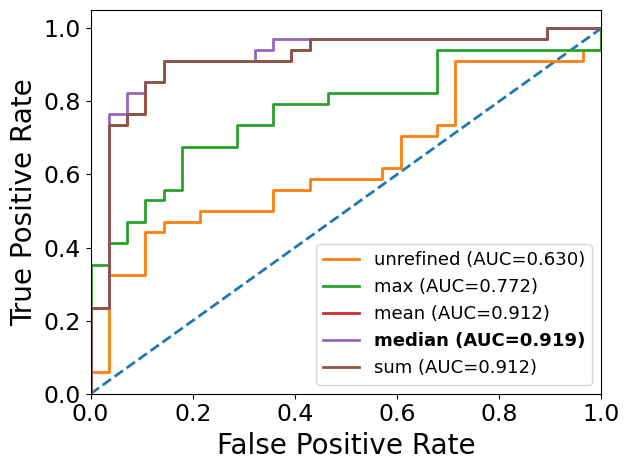

In [70]:
# Superimpose ROC curves for early high intensity hits
superimpose_roc_curves(
    iqm_norm_high_early_df_list,
    iqm_norm_high_early_auc_list,
    descriptions,
    os.path.join(iqm_norm_refined_subdir_name, suppl_mat_subdir_name),
    "early_high_intensity_hits",
    best_in_bold=True
)

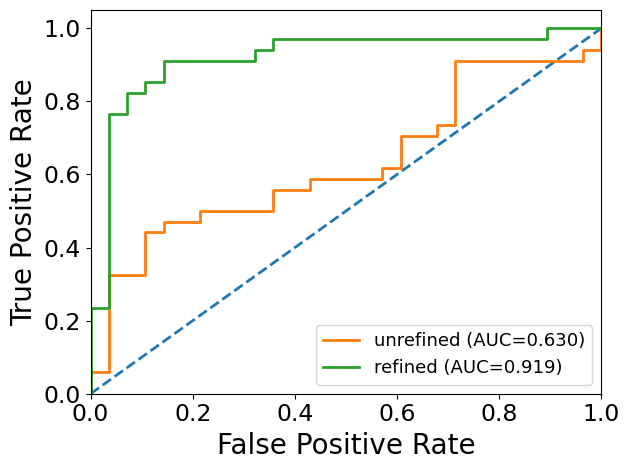

In [71]:
# Generate the plot for figure 1
# Extract the required elements located at indices 0 and 3
fig_1_iqm_norm_high_early_df_list = [
    iqm_norm_high_early_df_list[i] for i in fig_1_indices
]
fig_1_iqm_norm_high_early_auc_list = [
    iqm_norm_high_early_auc_list[i] for i in fig_1_indices
]

superimpose_roc_curves(
    fig_1_iqm_norm_high_early_df_list,
    fig_1_iqm_norm_high_early_auc_list,
    fig_1_descriptions,
    os.path.join(iqm_norm_refined_subdir_name, fig_1_subdir_name),
    "early_high_intensity_hits"
)

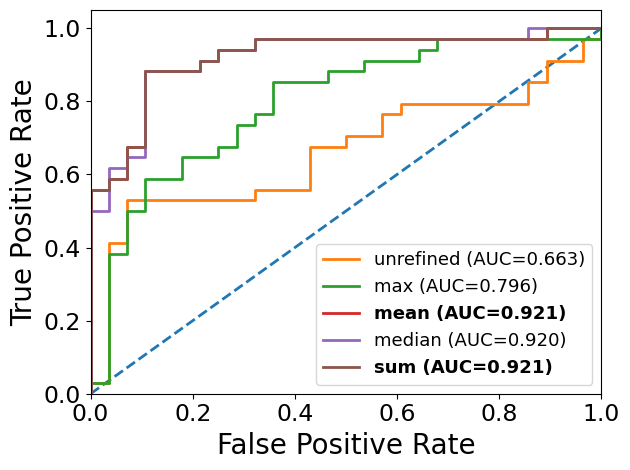

In [72]:
# Superimpose ROC curves for late high intensity hits
superimpose_roc_curves(
    iqm_norm_high_late_df_list,
    iqm_norm_high_late_auc_list,
    descriptions,
    os.path.join(iqm_norm_refined_subdir_name, suppl_mat_subdir_name),
    "late_high_intensity_hits",
    best_in_bold=True
)

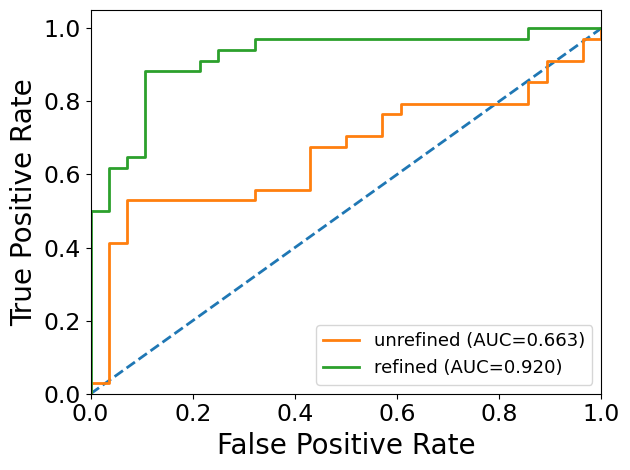

In [73]:
# Generate the plot for figure 1
# Extract the required elements located at indices 0 and 3
fig_1_iqm_norm_high_late_df_list = [
    iqm_norm_high_late_df_list[i] for i in fig_1_indices
]
fig_1_iqm_norm_high_late_auc_list = [
    iqm_norm_high_late_auc_list[i] for i in fig_1_indices
]

superimpose_roc_curves(
    fig_1_iqm_norm_high_late_df_list,
    fig_1_iqm_norm_high_late_auc_list,
    fig_1_descriptions,
    os.path.join(iqm_norm_refined_subdir_name, fig_1_subdir_name),
    "late_high_intensity_hits"
)

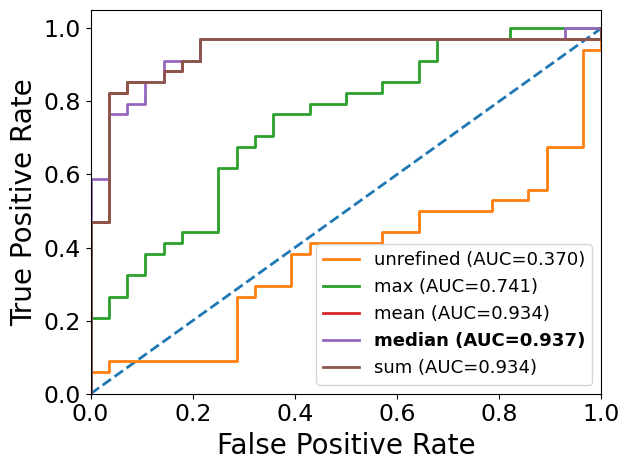

In [75]:
# Superimpose ROC curves for early low intensity hits
superimpose_roc_curves(
    iqm_norm_low_early_df_list,
    iqm_norm_low_early_auc_list,
    descriptions,
    os.path.join(iqm_norm_refined_subdir_name, suppl_mat_subdir_name),
    "early_low_intensity_hits",
    best_in_bold=True
)

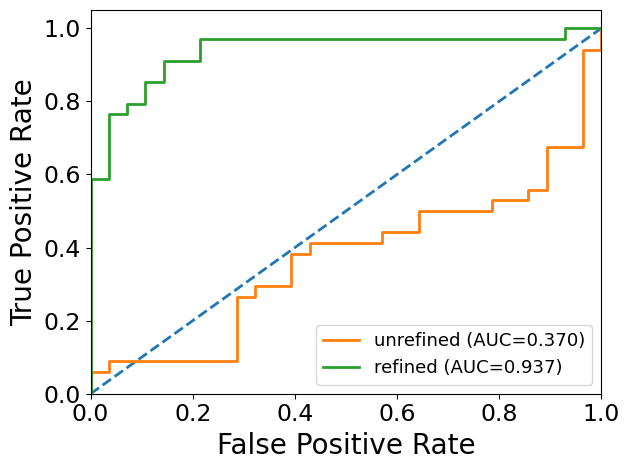

In [76]:
# Generate the plot for figure 1
# Extract the required elements located at indices 0 and 3
fig_1_iqm_norm_low_early_df_list = [
    iqm_norm_low_early_df_list[i] for i in fig_1_indices
]
fig_1_iqm_norm_low_early_auc_list = [
    iqm_norm_low_early_auc_list[i] for i in fig_1_indices
]

superimpose_roc_curves(
    fig_1_iqm_norm_low_early_df_list,
    fig_1_iqm_norm_low_early_auc_list,
    fig_1_descriptions,
    os.path.join(iqm_norm_refined_subdir_name, fig_1_subdir_name),
    "early_low_intensity_hits"
)

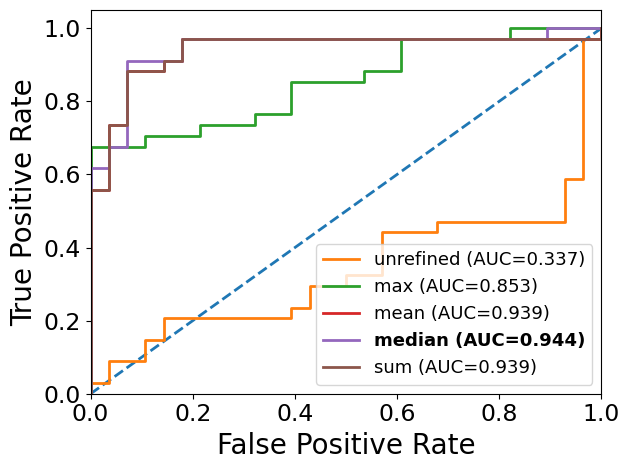

In [77]:
# Superimpose ROC curves for late low intensity hits
superimpose_roc_curves(
    iqm_norm_low_late_df_list,
    iqm_norm_low_late_auc_list,
    descriptions,
    os.path.join(iqm_norm_refined_subdir_name, suppl_mat_subdir_name),
    "late_low_intensity_hits",
    best_in_bold=True
)

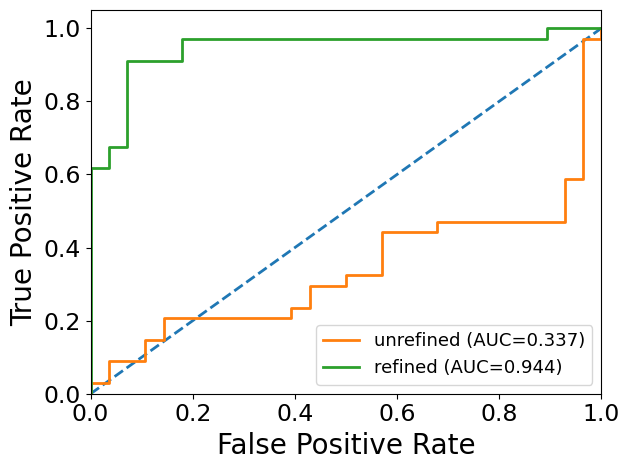

In [78]:
# Generate the plot for figure 1
# Extract the required elements located at indices 0 and 3
fig_1_iqm_norm_low_late_df_list = [
    iqm_norm_low_late_df_list[i] for i in fig_1_indices
]
fig_1_iqm_norm_low_late_auc_list = [
    iqm_norm_low_late_auc_list[i] for i in fig_1_indices
]

superimpose_roc_curves(
    fig_1_iqm_norm_low_late_df_list,
    fig_1_iqm_norm_low_late_auc_list,
    fig_1_descriptions,
    os.path.join(iqm_norm_refined_subdir_name, fig_1_subdir_name),
    "late_low_intensity_hits"
)